In [1]:
import torch
import linAlgHelper
from scipy.spatial import ConvexHull, HalfspaceIntersection
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import numpy as np
from neuralVolumeHelper import randCam, matrixLookat, createInputVector_planeHitModel,HiddenPrints, SIREN, getView, circular2sinCosC,bound2Mesh, compare2CenteredModels, bound2Pointcloud, meshIt, modelCenterCorrection, getPredictionPoints,compare2CenteredModels, bound2bounds, meshBoundsTM, mesh2pointcloud, array2Pointcloud
import open3d as o3d
import trimesh as tm



ball = tm.primitives.Capsule(radius=1., height=0.,sections=128)

class neuralConvexReconstruction:
    def __init__(self, center):
        self.learnModel = SIREN([11,64,64], lastlayer=False).cuda()
        self.learnModelLastLayer = SIREN([64], lastlayer=True).cuda()
        self.uncertaintyModel = torch.nn.Sequential(nn.Linear(12,256),nn.ReLU(),nn.Linear(256,67)).cuda()
        self.optimLearn = torch.optim.Adam(self.learnModel.parameters(), lr=0.01)
        self.optimLast = torch.optim.Adam(self.learnModelLastLayer.parameters(), lr=0.01)
        self.center = center
        self.optimCenter = torch.optim.Adam([self.center], lr=0.01)
    
    def train(self, centered_points, value):
        '''points are the n,3 karthesian coordinate points.  value is the certainty, that the point belongs to the convex part. It will have an effekt on the loss of the network.
            The value is initially derived from the differenciation inside-the bounds, outside (near) the bounds'''
        self.optimLast.zero_grad()
        self.optimLearn.zero_grad()
        self.optimCenter.zero_grad()
        prediction, difference, prediction1 = self.predict(centered_points)
        loss = torch.nn.functional.leaky_relu(difference*value, negative_slope=0.3).abs().sum()
        #Regularize Model center to Prediction center
        centerCorrection = modelCenterCorrection(self.learnModel,self.learnModelLastLayer)
        centerError = torch.nn.functional.l1_loss(self.center,centerCorrection)
        loss += centerError
        loss.backward()
        self.optimLast.step()
        self.optimLearn.step()
        self.optimCenter.step()
        self.optimLast.zero_grad()
        self.optimLearn.zero_grad()
        self.optimCenter.zero_grad()
        return difference.detach()
    
    def trainEmpty(self, empty_centered_points, size):
        self.optimLast.zero_grad()
        self.optimLearn.zero_grad()
        prediction, difference, prediction1 = self.predict(empty_centered_points)
        loss = torch.nn.functional.relu(-difference/size).abs().sum()
        loss.backward()
        self.optimLast.step()
        self.optimLearn.step()
        return difference.detach()
        
    def predict(self,centered_points):
            sphericalInput = linAlgHelper.asSpherical(centered_points)
            circularIn = circular2sinCosC(sphericalInput[:,:2].float())
            prediction1 = self.learnModel(circularIn)
            prediction = self.learnModelLastLayer(prediction1)
            difference = prediction-sphericalInput[:,2][:,None]
            return prediction, difference, prediction1
        
    def show(self, color = None):
        if color is None:
            color = np.random.rand(3)
        with torch.no_grad():
            sphericalInput = linAlgHelper.asSpherical(torch.tensor(ball.sample(10000)).float())[:,:2].cuda()
            circularIn = circular2sinCosC(sphericalInput[:,:2].float())
            prediction1 = self.learnModel(circularIn)
            prediction = self.learnModelLastLayer(prediction1)
            points = linAlgHelper.asCartesian(prediction).cpu()  
            pointcloudPoints = points+self.center.detach()
            pointcloud = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(pointcloudPoints))
            colors = np.ones_like(pointcloudPoints).astype(np.float64)
            colors[:,2] = colors[:,2]*color[2]
            colors[:,1] = colors[:,1]*color[1]
            colors[:,0] = colors[:,1]*color[0]
            pointcloud.colors = o3d.utility.Vector3dVector(colors)
            return pointcloud

In [4]:
class NeuralBound:
    pointDoubleOccupationVector = torch.Tensor([[]])
    neuralBoundList = []
    unoccupiedRegions = torch.Tensor([[]])
    pointsVolumeOverlapVector = torch.Tensor([[0.,0.,0.]]).cuda()
    pointsVolumeOverlapVectorDoubleOccupation = torch.Tensor([[0.,0.,0.]]).cuda()
    
    def createOccupationVector(points):
        NeuralBound.pointDoubleOccupationVector = torch.zeros_like(points[:,0]).cuda()
        NeuralBound.pointsVolumeOverlapVector = torch.Tensor([[0.,0.,0.]]).cuda()
        NeuralBound.pointsVolumeOverlapVectorDoubleOccupation = torch.Tensor([[0.,0.,0.]]).cuda()
        for volume in NeuralBound.neuralBoundList:
            volume.insideOccupationCheck1(points)
        NeuralBound.pointsVolumeOverlapVectorDoubleOccupation = torch.zeros_like(NeuralBound.pointsVolumeOverlapVector[:,0])
        for volume in NeuralBound.neuralBoundList:
            volume.insideOccupationCheck2()
        NeuralBound.unoccupiedRegions = NeuralBound.pointDoubleOccupationVector == 0
        NeuralBound.pointsVolumeOverlapVector = NeuralBound.pointsVolumeOverlapVector[NeuralBound.pointsVolumeOverlapVectorDoubleOccupation > 1]
        
    def __init__(self, 
                 additionalBounds = torch.Tensor([[0.75,0.75,0.75],
                                                    [-0.75,0.75,0.75],
                                                    [0.75,-0.75,0.75],
                                                    [0.75,0.75,-0.75],
                                                    [-0.75,-0.75,0.75],
                                                    [0.75,-0.75,-0.75],
                                                    [-0.75,0.75,-0.75],
                                                    [-0.75,-0.75,-0.75]]).cuda(),
                 boundsize = 0.3,
                 center=torch.Tensor([[0.,0.,0.]]), 
                 verbose=True,
                centerLR = 0.001,
                boundsLR = 0.01,
                variableFaktoren = [2,2,2,3,3,3,5.,1.,2.]):
        self.center = center.cuda()
        self.bounds = torch.Tensor([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.],[-1.,0.,0.],[0.,-1.,0.],[0.,0.,-1.]]).cuda()
        if additionalBounds is not None:
            self.bounds = torch.cat((self.bounds,additionalBounds),0)*boundsize
        self.bounds = self.bounds.cuda()
        self.name = "newBound"
        self.verbose = verbose
        self.center.requires_grad = True
        self.bounds.requires_grad = True
        self.centerOptim = torch.optim.Adam([self.center], lr=centerLR)
        self.boundsOptim = torch.optim.Adam([self.bounds], lr=boundsLR)
        self.variableFaktoren = variableFaktoren
        self.neuralReconstruction = neuralConvexReconstruction(self.center)
        NeuralBound.neuralBoundList.append(self)
        if self.verbose:
            print("{} was created at {}".format(self.name, self.center.cpu().detach()))
    
    def getVolume(self):
        return (self.bounds[0]-self.bounds[3])[0].detach()*(self.bounds[1]-self.bounds[4])[1].detach()*(self.bounds[2]-self.bounds[5])[2].detach()
    
    def clampBounds(self):
        with torch.no_grad():
            self.bounds[0,0].clamp(-99999,-0.01)
            self.bounds[0,1] = 0.
            self.bounds[0,2] = 0.
            self.bounds[3,0].clamp(0.01,99999)
            self.bounds[3,1] = 0.
            self.bounds[3,2] = 0.
            self.bounds[1,1].clamp(-99999,-0.01)
            self.bounds[1,0] = 0.
            self.bounds[1,2] = 0.
            self.bounds[4,1].clamp(0.01,99999)
            self.bounds[4,0] = 0.
            self.bounds[4,2] = 0.
            self.bounds[2,2].clamp(-99999,-0.01)
            self.bounds[2,0] = 0.
            self.bounds[2,1] = 0.
            self.bounds[5,2].clamp(0.01,99999)
            self.bounds[5,0] = 0.
            self.bounds[5,1] = 0.
        
    def insideOccupationCheck1(self, points):
        '''Takes only surfacepoints (n,3)'''
        with torch.no_grad():
            centeredPoints = points-self.center
            boundsTest = linAlgHelper.getPointDistances2PlaneNormal(centeredPoints[None,:,:], self.bounds[None,:,:])[0]
            inside = boundsTest>0
            completeInner = inside.sum(dim=1)==inside.shape[1]
            NeuralBound.pointDoubleOccupationVector += completeInner*1
            size = self.bounds[:6].detach().abs().max()
            NeuralBound.pointsVolumeOverlapVector = torch.cat([NeuralBound.pointsVolumeOverlapVector,
                                                              (torch.rand(10000+100*int(size**2),3).cuda()-0.5)*2*size+self.center],0)
    
    def insideOccupationCheck2(self):
        with torch.no_grad():
            centeredPoints = NeuralBound.pointsVolumeOverlapVector-self.center
            boundsTest = linAlgHelper.getPointDistances2PlaneNormal(centeredPoints[None,:,:], self.bounds[None,:,:])[0]
            inside = boundsTest>0
            completeInner = inside.sum(dim=1)==inside.shape[1]
            NeuralBound.pointsVolumeOverlapVectorDoubleOccupation += completeInner*1
    
    def boundsAdjustmentStep(self, surfacepoints, emptyVectors):
        '''gets tensor(n,3) surfacespoints (surface ) with (n,1) values (1 for surface, -1 for empty)'''
        size = self.bounds[:6].detach().abs().max()
        #create empty points
        emptypoints = torch.cat((surfacepoints+emptyVectors*0.1,
                                 surfacepoints+emptyVectors*0.2,
                                 surfacepoints+emptyVectors*0.4,
                                 surfacepoints+emptyVectors*size*0.3),0)        
        self.clampBounds()
        self.centerOptim.zero_grad()
        self.boundsOptim.zero_grad()
        centeredPoints_surface = surfacepoints-self.center
        centeredPoints_empty = emptypoints-self.center
        if len(NeuralBound.pointsVolumeOverlapVector) > 0:
            centeredPoints_doubleOcc = NeuralBound.pointsVolumeOverlapVector - self.center
        boundsTest_surface = linAlgHelper.getPointDistances2PlaneNormal(centeredPoints_surface[None,:,:], self.bounds[None,:,:])[0]
        boundsTest_empty = linAlgHelper.getPointDistances2PlaneNormal(centeredPoints_empty[None,:,:], self.bounds[None,:,:])[0]
        if len(NeuralBound.pointsVolumeOverlapVector) > 0:
            boundsTest_doubleOcc = linAlgHelper.getPointDistances2PlaneNormal(centeredPoints_doubleOcc[None,:,:], self.bounds[None,:,:])[0]
        with torch.no_grad():
            near_surface = boundsTest_surface>-size*self.variableFaktoren[0]   #self.variableFaktoren[2] = 1.0
            completeNear_surface = near_surface.sum(dim=1)==near_surface.shape[1]
            near_empty = boundsTest_empty>-size*self.variableFaktoren[1]   #self.variableFaktoren[2] = 1.0
            completeNear_empty = near_empty.sum(dim=1)==near_empty.shape[1]
            if len(NeuralBound.pointsVolumeOverlapVector) > 0:
                near_doubleOcc = boundsTest_doubleOcc>-size*self.variableFaktoren[2]   #self.variableFaktoren[2] = 1.0
                completeNear_doubleOcc = near_doubleOcc.sum(dim=1)==near_doubleOcc.shape[1]
        insideGradient_empty = torch.nn.functional.leaky_relu(torch.tanh(boundsTest_empty/(size*self.variableFaktoren[3])),0.001)
        outsideGradient_surface = torch.nn.functional.leaky_relu(torch.tanh(-boundsTest_surface/(size*self.variableFaktoren[4])),0.001)
        value = torch.tanh(boundsTest_surface.detach()[completeNear_surface]/(size)).prod(dim=1)
        #train neural reconstruction -bounds influence training value
        points = centeredPoints_surface.detach()[completeNear_surface]
        differenceExists = False
        if len(points) > 0:
            difference = self.neuralReconstruction.train(points, value)
            differenceExists = True
        points = centeredPoints_empty.detach()[completeNear_empty]
        if len(points) > 0:
            self.neuralReconstruction.trainEmpty(points, size)
        # a small difference means a good reconstruction - that means a very valuable point for boundary adjustment
        value = torch.zeros_like(completeNear_surface, dtype=torch.float32)
        if differenceExists:
            value[completeNear_surface] = 0.1 + 1./(difference.abs()+0.01*size)[:,0]
        if len(NeuralBound.pointsVolumeOverlapVector) > 0:
            insideGradient_doubleOcc = torch.nn.functional.leaky_relu(torch.tanh(boundsTest_doubleOcc/(size*self.variableFaktoren[5])),0.001)
            overLapFactor = completeNear_doubleOcc[:,None]  #smaller negative value to encourage seamless reconstructions
            overlapLoss = insideGradient_doubleOcc* overLapFactor
        missedPointFactor = (value*completeNear_surface*NeuralBound.unoccupiedRegions)[:,None]
        missedPointsLoss = outsideGradient_surface*missedPointFactor#*importance_surface**self.variableFaktoren[9]
        # for the inner loss: errors near a plane are important, but the gradient of the error should shrink, the nearer it gets
        innerEmptyFactor = completeNear_empty[:,None]
        innerEmptyLoss= insideGradient_empty*innerEmptyFactor
        if len(NeuralBound.pointsVolumeOverlapVector) > 0:
            error = self.variableFaktoren[6]*overlapLoss.sum() + self.variableFaktoren[7]*missedPointsLoss.sum()+ self.variableFaktoren[8]*innerEmptyLoss.sum() 
        else:
            error = self.variableFaktoren[7]*missedPointsLoss.sum()+ self.variableFaktoren[8]*innerEmptyLoss.sum() 
        #print("overlap: ",overlapLoss.detach().sum().item(), " missedPoints: ", missedPointsLoss.detach().sum().item(), " innerEmpty: ", innerEmptyLoss.detach().sum().item())
        error.backward()
        self.centerOptim.step()
        self.boundsOptim.step()
        self.clampBounds()
        self.centerOptim.zero_grad()
        self.boundsOptim.zero_grad()

        return {"overlap":overlapLoss.detach().sum().item() if len(NeuralBound.pointsVolumeOverlapVector) > 0  else 0.,
                "missedPoints": missedPointsLoss.detach().sum().item(),
                "inside Empty": innerEmptyLoss.detach().sum().item()               
                }
    
    
    def train(points, cameraPosition):
        '''surface points in (n,3) and cameraposition in (3)'''
        points = points.cuda()
        loss = {"overlap":0.,
                "missedPoints": 0.,
                "inside Empty": 0.}
        NeuralBound.createOccupationVector(points)
        emptyVectors = (cameraPosition[None,:].cuda()-points).reshape(-1,3)
        emptyVectors = emptyVectors/((emptyVectors**2).sum(dim=-1))[:,None]**0.5
        for volume in NeuralBound.neuralBoundList:
            tempLoss = volume.boundsAdjustmentStep(points,emptyVectors)
            loss["overlap"] += tempLoss["overlap"]
            loss["missedPoints"] += tempLoss["missedPoints"]
            loss["inside Empty"] += tempLoss["inside Empty"]
        return loss
    
    def show(self):
        size = self.bounds[:6].detach().abs().max()
        data = (torch.rand(10000,3).cuda()-0.5)*2.*size
        boundsTest = linAlgHelper.getPointDistances2PlaneNormal(data[None,:,:], self.bounds.detach()[None,:,:])[0]
        inside = boundsTest>0
        inside = inside.sum(dim=1)==inside.shape[1]
        filtered = data[inside].cpu()
        filteredIdx = torch.arange(len(filtered))
        hull = ConvexHull(filtered)
        verts_ = torch.tensor(hull.vertices)
        vertIdx = torch.arange(len(verts_))
        filteredIdx[verts_.long()] = vertIdx
        faces_ = torch.tensor(hull.simplices)
        vertices, faces =  filtered[verts_.long()]+self.center.detach().cpu(), filteredIdx[faces_.long()]
        mesh = tm.Trimesh(vertices=vertices, faces=faces)
        pointcloudPoints = mesh.sample(2000)
        pointcloudMesh = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(pointcloudPoints))
        colors = np.ones_like(pointcloudPoints).astype(np.float64)
        colors[:,2] = colors[:,2]*np.random.rand()
        colors[:,1] = colors[:,1]*np.random.rand()
        colors[:,0] = colors[:,0]*np.random.rand()
        pointcloudMesh.colors = o3d.utility.Vector3dVector(colors)
        return(pointcloudMesh)

        

In [11]:
        
pointsData = torch.load("points.pt")
camPositions = torch.load("camPositions.pt")


volumesNr = 10

volumeStarts = pointsData[0][:volumesNr]
emptyvec = camPositions[0][None,:]-volumeStarts
emptyvec = emptyvec/(emptyvec**2).sum(dim=-1)[:,None]**0.5

trainNr = 0

gridparameter = []   # 0: nearSurfaceFaktor, 
                    # 1: nearEmptyFaktor, 
                    # 2: nearDoubleOccFaktor, 
                    # 3: insideEmptySigmoidFaktor, 
                    # 4: missedPointLossSigmoidFaktor,
                    # 5: volumeOverlapSigmoidFaktor, 
                    # 6: overLapFactor
                    # 7: missedPointFaktor,
                    # 8:innerEmptyFaktor,
                    # 9: LR center
                    # 10: LR bounds
nearSurfaceFaktor = [0.75]
nearEmptyFaktor = [0.]
nearDoubleOccFaktor = [0.]
insideEmptySigmoidFaktor = [5.]
missedPointLossSigmoidFaktor = [5.]
volumeOverlapSigmoidFaktor = [5.]
overLapFactorChoice = [5]
missedPointFaktor = [5]
innerEmptyFaktor = [1]
LR_center = [0.01]
LR_bounds = [0.01]

#create search:
for i in range(1):
    gridparameter=torch.tensor([np.random.choice(nearSurfaceFaktor,1),
                    np.random.choice(nearEmptyFaktor,1),
                    np.random.choice(nearDoubleOccFaktor,1),
                    np.random.choice(insideEmptySigmoidFaktor,1),
                    np.random.choice(missedPointLossSigmoidFaktor,1),
                    np.random.choice(volumeOverlapSigmoidFaktor,1),
                    np.random.choice(overLapFactorChoice,1),
                    np.random.choice(missedPointFaktor,1),
                    np.random.choice(innerEmptyFaktor,1),
                    np.random.choice(LR_center,1),
                    np.random.choice(LR_bounds,1)])[:,0]
    NeuralBound.neuralBoundList = []
    bounds = []
    for i in range(volumesNr):
        #training des neural Volumes
        bounds.append(NeuralBound(boundsize = 0.05,
                        center=torch.tensor(volumeStarts[i]-0.05*emptyvec[i]).cuda(), 
                        verbose=False,
                        centerLR = gridparameter[-2],
                        boundsLR = gridparameter[-1],
                        variableFaktoren= torch.tensor(gridparameter[:-2]).cuda()))


<ipython-input-11-b563503fbcd0>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  center=torch.tensor(volumeStarts[i]-0.05*emptyvec[i]).cuda(),
<ipython-input-11-b563503fbcd0>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  variableFaktoren= torch.tensor(gridparameter[:-2]).cuda()))


In [12]:
path = []

if True:
    print("beginning Training Nr: ",trainNr)
    for iter_idx in range(500):
        points = pointsData[iter_idx].cuda()
        camPosition = camPositions[iter_idx].cuda()
        newLoss = NeuralBound.train(points, camPosition)
        if iter_idx %100 == 99:
            print("     ",iter_idx," of 1000")
            path.append(NeuralBound.neuralBoundList[0].show())

beginning Training Nr:  0


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [ ]:
pointcloudTarget = torch.cat(pointsData[:16],0).cpu()
mask = np.random.choice(torch.arange(len(pointcloudTarget)),10000)
pointcloudT = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(pointcloudTarget[mask]))
colors = np.ones_like(pointcloudTarget).astype(np.float64)
colors[:,2] = colors[:,0]*0.
colors[:,0] = colors[:,1]*0.
pointcloudT.colors = o3d.utility.Vector3dVector(colors)



pointClouds = []
for v in NeuralBound.neuralBoundList:
    try:
        pointClouds.append(v.show())
    except:
        pass

o3d.visualization.draw_geometries( [pointcloudT]+pointClouds)

# neural net

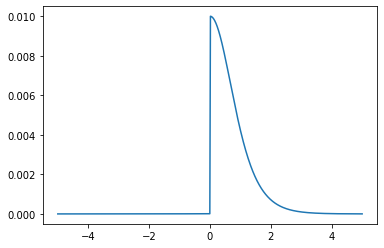

In [7]:
import matplotlib.pyplot as plt

x = torch.linspace(-5,5,1000)
y = torch.nn.functional.leaky_relu(torch.tanh(x/(1)),0.001)-torch.nn.functional.leaky_relu(torch.tanh((x-0.01)/(1)),0.001)

plt.plot(x,y)